In [1]:
import pickle as pkl
import sys
import torch
import builder
import torchvision.models as models
import numpy as np
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from PIL import Image
import os
import matplotlib.patches as patches


In [120]:
class PascalVOCDataset(Dataset):
    
    def __init__(self, data_folder, split):

        split.lower()
        assert split in {'train', 'test'}

        self.split = split
        self.data_folder = data_folder
        
        #train+val come from both 2007 and 2012, test comes from 2007
        if split == 'train': 
            loc = [data_folder + '/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt',
                   data_folder + '/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt']
        elif split == 'test':
            loc = [data_folder + '/VOCdevkit/VOC2007/ImageSets/Main/test.txt']
        
        
        self.images = []
        self.file_names = []

        #Get the Image locations for each of the datasets 
        for file in loc:
            image_path = file[0:len('datasets/VOCdevkit/VOC2007///')] + 'JPEGImages/'

            with open(file,'rb') as f:
                content = f.readlines()
            [self.images.append(image_path + (x.strip().decode('utf-8')) + '.jpg') for x in content]
            [self.file_names.append(x.strip().decode('utf-8')) for x in content]
      
    
        #Get the Associated Objects (Bounding boxes, etc)
        self.objects = []
        
        for xml in self.file_names:
            if os.path.isfile('./datasets/VOCdevkit/VOC2007/Annotations/' + xml + '.xml'):
                output = read_content('./datasets/VOCdevkit/VOC2007/Annotations/' + xml + '.xml')
                self.objects.append(output)
            elif os.path.isfile('./datasets/VOCdevkit/VOC2012/Annotations/' + xml + '.xml'):
                output = read_content('./datasets/VOCdevkit/VOC2012/Annotations/' + xml + '.xml')
                self.objects.append(output)
        
        print(len(self.images), len(self.objects))
    def __getitem__(self,i):
        
        image = Image.open(self.images[i], mode = 'r')
        image = image.convert('RGB')
        
        objects = self.objects[i]
        print(objects)
        
        boxes = torch.FloatTensor(objects[0])
        
        labels = torch.LongTensor(objects[1])
        
        #show(image, boxes.numpy())
        images = extract_objects(image,boxes.numpy())
        
        return images, labels
    
    
    def __len__(self):
        return len(self.images)
    
#Reads the content of the xml file for the dataloader
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    labels = []
    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

        labels.append(boxes.find('name').text)

    return (list_with_all_boxes, oneHotEncodeClassLabels(labels))


def oneHotEncodeClassLabels(labels : list):
    classes = ['background','aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    one_hot = [classes.index(i) for i in labels] 
    return one_hot


def show(image, bbs):
    fig, ax = plt.subplots(1)
    plt.imshow(image)
    print(image)
    
    #Show original image
    for bb in bbs:
        height = bb[3] - bb[1]
        width = bb[2] - bb[0]
        rect = patches.Rectangle((bb[0],bb[1]),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    
    #Show subimages
    for bb in bbs:
        figt,ax = plt.subplots()
        plt.imshow(image.crop((bb[0],bb[1],bb[2],bb[3])))

def extract_objects(image,bbs):
    image_list = []
    for bb in bbs:
        image_list.append(image.crop((bb[0],bb[1],bb[2],bb[3])))
    return image_list

In [121]:
train_data = PascalVOCDataset('./datasets', 'train')
test_data = PascalVOCDataset('./datasets', 'test')

train_data[2]

16551 16551
4952 4952
([[69, 172, 270, 330], [150, 141, 229, 284], [285, 201, 327, 331], [258, 198, 297, 329]], [13, 15, 15, 15])


([<PIL.Image.Image image mode=RGB size=201x158 at 0x7F029E9FA820>,
  <PIL.Image.Image image mode=RGB size=79x143 at 0x7F03106FD280>,
  <PIL.Image.Image image mode=RGB size=42x130 at 0x7F03106FD730>,
  <PIL.Image.Image image mode=RGB size=39x131 at 0x7F03106FD340>],
 tensor([13, 15, 15, 15]))

In [122]:
train_data[3]

([[156, 97, 351, 270]], [7])


([<PIL.Image.Image image mode=RGB size=195x173 at 0x7F029A883C40>],
 tensor([7]))

([[156, 97, 351, 270]], [7])
<PIL.Image.Image image mode=RGB size=224x224 at 0x7F029CBBC070>


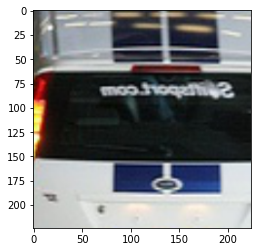

In [164]:
class TransformList(object):
    def __init__(self,output_dim, crop_size):
        self.output_dim = output_dim
        self.scale = scale
    
    def __call__(self, samples):
        samples =  [transforms.RandomHorizontalFlip()(x) for x in samples[0]]
        samples =  [transforms.RandomResizedCrop(size = self.output_dim,scale = (0.08,1))(x) for x in samples]
        samples =  [transforms.Resize(self.output_dim)(x) for x in samples]
        return samples
    
scale = TransformList(224, (224,224))
composed = transforms.Compose(Rescale(224))
sample = train_data[3]

    
for i, tsfrm in enumerate([scale]):
    transformed_sample = tsfrm(sample)

for i in transformed_sample:
    fig, ax = plt.subplots(1)
    plt.imshow(i)
    print(i)

In [157]:
sample[0]

[<PIL.Image.Image image mode=RGB size=195x173 at 0x7F029CB76430>]

In [128]:
transformed_sample[3]

IndexError: list index out of range